# Modelling patch-clamp experiments: electronic compensation

In the [last notebook](./artefacts-1-modelling-patch-clamp.ipynb), we introduced an electrical schematic that can serve as a model of the patch-clamp set up, with distortions by leak, offsets, and unwanted capacitances.
To compensate for these unwanted effects, patch-clamp amplifiers contain special circuitry.
In this notebook we extend our model to include the effects of these compensations, based on the model in [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0348) - but with some notable updates and differences.

We will deal mostly with _transient_ distortions of the recorded output signal, which we call _artefacts_, and with transient differences between the true and intended membrane potential, which are an example of _imperfect control_.
These terms, and general strategies for dealing with their effects, are discussed in [Appendix D1](./appendix-D1-strategies.ipynb).
Stochastic and periodic noise are not discussed here, but a brief discussion is given in [Appendix D2](./appendix-D2-inspecting-noise.ipynb).

## Zeroing and the liquid junction potential ($E_\text{off}$)

In the last notebook we introduced $E_\text{off}$, which represents the sum of various voltage offsets that are incurred in the experimental setup.
This offset is usually corrected by a dial or a digital control that allows the experimenter to subtract an equal offset $-E_\text{off}^*$.
To allow for the idea that this correction is imperfect, either because it was set imperfectly or because $E_\text{off}$ drifted over time, we now introduce a symbol for the error in the offset correction $E_\text{off}^\dagger$ as
\begin{equation}
E_\text{off}^\dagger = E_\text{off} - E_\text{off}^*
\end{equation}

In the schematic, we will simply replace $E_\text{off}$ with the remaining error.

<img src="resources/patch-comp-1-Eoff.png" />

_**Figure 1**: The voltage offset has been corrected until only a small error_ $E_\text{off}^\dagger$ _remains._

### The liquid junction potential

A liquid junction potential (LJP) arises wherever two liquids containing different concentrations of ions are in contact.
In manual patch clamp this is the case just before the experiment, when the pipette is in the bath but not yet attached to the cell, so that the pipette fluid is in contact with the bath fluid.
The correction $E_\text{off}*$ is usually determined just before the final approach to the cell, and so includes this LJP.

Once a connection to the cell is made, the pipette fluid is in contact with the cytosol and because both fluids are similar an LJP no longer occurs.
This means that our correction $E_\text{off}*$ was made in the presence of an LJP that no longer occurs, and we are now _overcorrecting_.

The correction for this overcorrection is called LJP correction, and proceeds as follows:

1. The LJP is calculated by entering the bath and pipette solutions into an LJP calculating program. This is not as simple as it sounds: buffering of e.g. calcium by calcium buffers must be taken into account, and often solutions are pH corrected by adding NaOH or KOH, which should also be taken into account in the LJP calculation.
2. We can then adjust all $V_\text{cmd}$ values to obtain the desired $V_m$ (*a priori* correction) or simply accept that $V_m$ is shifted from the desired value and account for this in our analysis (*a posteriori* correction). 

Some systems allow the LJP to be entered into the recording software, so that *a priori* correction can be performed without further user input.

A detailed description of the correction procedure is provided in [Appendix D3](./appendix-D3-liquid-junction-potential.ipynb).
In short, if you have to do manual *a posteriori* correction then you **subtract** the LJP from the applied or measured voltage to get the true value.

In the remainder of this notebook we will assume LJP correction has been performed a priori by adjusting $V_\text{cmd}$.
We will treat $E_\text{off}^\dagger$ as a small number that does not include the LJP.

## Frequency response correction ($C_f$)

Combined with the feedback resistance $R_f$, the stray capacitance $C_f$ determines the time constant $\tau_f = R_f C_f$ which affects the speed with which the op-amp can change the pipette voltage $V_p$.
In electronics parlance, which is heavily geared towards periodic signals, we can say $\tau_f$ determines the op-amp's _bandwidth_ or _frequency response_.

For typical values of $R_f$ and $C_f$, given in [Appendix C3](./appendix-C3-parameter-values.ipynb), we find $\tau_f$ values of 0.08ms to 1ms.
Because thes values would lead to unacceptably slow voltage-clamps, amplifiers such as the HEKA EPC-10 or the Axopatch 200B contain "high frequency boost" circuitry that greatly reduces the apparent $\tau_f$ value ([Sigworth (1995b) Design of the EPC-9, a computer-controlled patch-clamp amplifier, 1 Hardware](https://doi.org/10.1016/0165-0270(94)00128-4), [Axopatch 200B manual](https://support.moleculardevices.com/s/article/Axon-AxoPatch-Manual-Download-Page)).
The work by Sigworth suggests an apparent value of 4 $\mu$s for the HEKA EPC-9.
By fitting to measurements made with an EPC-10 we found a value of around 2 $\mu$s.

To include this in the model, we shall stick to the $R_f$ values specified by the hardware manufacturers, but replace $C_f$ by an _apparent_ value $\tilde{C}_f$.

<img src="resources/patch-comp-2-Cf-apparent.png" />

_**Figure 2**: The "high frequency boost" is modelled by replacing $C_f$ with a much smaller apparent value, $\tilde{C}_f$._

## Capacitance correction ($C_p$ and $C_m$), part 1

Whenever $V_p$ changes, the capacitors $C_p$ and $C_m$ will be charged or uncharged, and the associated charging currents will show up in our measured currents.
With the step protocols favoured by electrophysiologists, these charging currents can be very large and cause problems for the voltage-clamp circuitry (see also [Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4)):

1. The large charging currents can exceed the limits of the A/D converter used to digitise the output voltage. For the samples during which this _clipping_ occurs, we record only the maximum (or minimum) value, so information about the current is lost. Amplifiers in the A/D converter may also go into _saturation_, which significantly prolongs the clipping and leads to further signal loss.
2. Large transient currents can cause the op amp in the feedback circuit to saturate, leading to a loss of control over the membrane voltage until the amplifier has recovered.

To avoid these problems, we introduce a separate pathway to charge $C_p$ and $C_m$, which bypasses the feedback amplifier.
In the diagram below we show this using an active component (unlabelled), which "injects" a charging current $I_\text{inj}$ into the system, based on $V_c$, but without drawing in any current at its input.

<img src="resources/patch-comp-3-Iinj.png" />

_**Figure 3**: Capacitance correction aims to charge $C_p$ and $C_m$ without affecting $V_\text{out}$ ._

The injected current is determined using estimates $C_p^*$ and $C_m^*$ of the parasitic and membrane capacitance, and depends on the derivative of the command potential $\dot{V_c}$:
\begin{align}
I_\text{inj} = (C_p^* + C_m^*) \dot{V}_c
\end{align}

### Stimulus filter

For voltage step protocols, the $\dot{V}_c$ term in the above equation is theoretically either $0$, during steps, or $\pm\infty$, at transitions.
In practice, we might expect some "rounding" to occur leading to less extreme values.
The HEKA amplifiers further reduce the voltage artefacts (and corrections) by adding a _stimulus filter_ over the command potential $V_c$, as shown in the diagram below.

<img src="resources/patch-comp-4-stim-filter.png" />

_**Figure 4**: The stimulus filter reduces the size of capacitative artefacts._

Here $F_s$ represents a filtering of $V_c$ resulting in the voltage $V_s$.
As a first approximation we can represent this in equations as
\begin{align}
\dot{V_s} = \frac{V_c - V_s}{\tau_s}
\end{align}
where $\tau_s \approx 25 \mu s$ (see [Appendix A4](./appendix-A4-bessel-filters.ipynb)).

With the stimulus filter in place, the capacitance correction becomes
\begin{align}
I_\text{inj} = (C_p^* + C_m^*) \dot{V}_s
\end{align}

After introducing series resistance compensation in the next section, we will further refine this capacitance correction.

## Series resistance compensation ($R_s$)

The _series resistance_ causes two issues for controlling the membrane potential:

1. It causes a voltage drop, so that $V_m$ is not quite equal to the intended voltage $V_p$.
2. It causes the membrane voltage to lag behind the desired voltage, with a time constant $R_sC_m$.

To compensate for these effects, we will increase the voltage clamp potential a little bit above the desired command potential $V_c$.
Two separate mechanisms are used.
A feed-forward _correction_ mechanism based on the observed current corrects for the voltage drop,
while a _prediction_ (or "supercharging") mechanism based on the estimated membrane potential speeds up the charging process.

### "Correction" reduces the voltage drop

A common method to compensate for the voltage drop, is to _feed a fraction of_ $V_\text{out}$ _forward into_ $V_c$ ([Hodgkin et al. 1952](https://physoc.onlinelibrary.wiley.com/doi/10.1113/jphysiol.1952.sp004716)).
In the schematic, we'll show this with two new components: an active component labelled $\alpha$ that sets the voltage to be added, and a _summing amplifier_, labelled $\Sigma$:

<img src="resources/patch-comp-5-Rs-corr.png" />

_**Figure 5**: Series resistance correction feeds a fraction of_ $V_\text{out}$ _into_ $V_\text{ref}$ _via a summing amplifier._

In this new set-up

\begin{align}
V_\text{out} = V_o - V_\text{ref}
\end{align}

And so the extra voltage added by the series resistance compensation will be zero when $V_o = V_\text{ref}$.

To analyse the effect of feed-forward on the voltage drop over $R_s$, we use the simplified schematic shown below.

<img src="resources/patch-comp-6-Rs-simplified.png" />

_**Figure 6**: A simplified schematic for_ $R_s$ _correction._

Using $x$ for the fraction of $V_\text{out}$ fed into $V_\text{ref}$ we find
\begin{align}
V_\text{ref} = V_s + x V_\text{out} = V_s + x R_f I_\text{obs}
\end{align}

With this, we can write an equation for the membrane voltage $V_m$ as
\begin{align}
V_m &= V_p - R_s I \\
    &\approx V_\text{ref} - R_s I \\
    &= V_s + x R_f I_\text{obs} - R_s I \\
    &\approx V_s + (x R_f - R_s) I
\end{align}

where we assume first a perfect op amp ($V_p \approx V_\text{ref}$) and then a perfect measurement ($I \approx I_\text{obs}$).
The error in the voltage is given by
$V_m - V_s \approx (x R_f - R_s) I$
so if we can choose $x R_f = R_s$ we can compensate for the voltage drop over $R_s$ entirely.

To implement this, we will make an estimate of the series resistance, $R_s^*$, and choose $x$ so that $x R_f = R_s^*$.
We can then write:

\begin{align}
V_\text{ref} = V_s + R_s^* I_\text{obs}
\end{align}

In practice, the various delays and imperfections in the system can easily create a situation where the feed-forward causes oscillations  or "ringing" in the system.
To alleviate this, we only compensate a fraction $\alpha$ of the estimated resistance:

\begin{align}
V_\text{ref} = V_s + \alpha R_s^* I_\text{obs} = V_s + \alpha \frac{R_s^*}{R_f} V_\text{out} 
\end{align}

where $\alpha$ is usually limited to about 70 or 80% ([Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4)).

### Incorporating a "lag"

To increase the stability of the compensation, patch-clamp amplifiers typically use a filtered version of $V_\text{out}$ in series resistance compensation, which lags behind the real $V_\text{out}$ with a user-specified time constant.
For example, in the Axopatch 200B this is implemented with a "1-pole low-pass filter" (see [Appendix A4](./appendix-A4-bessel-filters.ipynb) for more about filters).

To model this, we introduce a filtered version of $V_\text{out}$, which we will call $V_\text{rc}$, and a user-specified time constant $\tau_\text{rc}$.
We update the schematic as follows:

<img src="resources/patch-comp-7-Rs-lag.png" />

_**Figure 7**: A low-pass filter on $V_\text{out}$ adds a user-specified "lag" on the series resistance correction._

And write

\begin{align}
V_\text{ref} = V_s + \alpha \frac{R_s^*}{R_f} V_\text{rc}
\end{align}
\begin{align}
\dot{V}_\text{rc} = \frac{V_\text{out} - V_\text{rc}}{\tau_\text{rc}}
\end{align}

Where a typical value for $\tau_\text{rc}$ is $10\mu s$ (see [Appendix C3](./appendix-C3-parameter-values.ipynb)).

### "Prediction" speeds up the charging process

At this point, it becomes necessary to revisit the capacitance correction.
Using the feedback scheme above, we corrected for the series resistance $R_s$ by adding in a term proportional to $I_\text{obs}$.
The current to charge $C_m$ also flows through $R_s$, but is not accounted for by $I_\text{obs}$ when capacitance correction is used.

(Note that, in our schematic, the current to charge $C_p$ does _not_ flow through $R_s$. In the real set-up, part of the capacitance represented by our $C_p$ may occur after $R_s$, so this is an approximation.)

To remedy this, we address membrane charging seperately, by

1. Making a _prediction_ of $V_m$, as affected by $R_sC_m$
2. Speed up the charging process by temporarily applying an exaggerated voltage.

For the estimated membrane potential, _without any compensation_, we will write
\begin{align}
\dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{R_s^*C_m^*}   
\end{align}
where $R_s^*$ and $C_m^*$ are estimates of the series resistance and membrane capacitance.
If we can compensate for a fraction $\beta$ of $R_s$, we can estimate the remaining series resistance as $(1 - \beta)R_s^*$, to find
\begin{align}
\dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}
\end{align}

Next, we update the reference voltage by adding a term $\beta R_s^*C_m^* \dot{V}_\text{est}$:
\begin{align}
V_\text{ref} = V_s + \alpha \frac{R_s^*}{R_f} V_\text{rc} + \beta R_s^* C_m^* \dot{V}_\text{est}
\end{align}
which we can also write as
\begin{align}
V_\text{ref} &= V_s + \alpha \frac{R_s^*}{R_f} V_\text{rc} + \beta R_s^* C_m^* \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*} \\
    &= V_s + \alpha \frac{R_s^*}{R_f} V_\text{rc} + \frac{\beta}{1 - \beta} (V_s - V_\text{est}) \\
    &= \alpha \frac{R_s^*}{R_f} V_\text{rc} + \frac{V_s - \beta V_\text{est}}{1 - \beta}
\end{align}

A schematic including both types of $R_s$ compensation is shown below:

<img src="resources/patch-comp-8-Rs-pred.png" />

_**Figure 8**: Series resistance prediction (left) and correction (right)._

The addition of the predicted charging current causes a significant "overshoot" in $V_\text{ref}$, which has been likened to the _supercharging_ method of [Armstrong & Chow (1987)](https://doi.org/10.1016/S0006-3495(87)83198-3).

A derivation of the prediction equations from the schematics by Sigworth is given in [appendix B3](./appendix-B3-sigworth-rs.ipynb).


## Capacitance correction ($C_p$ and $C_m$), part 2

Having introduced $V_\text{est}$ and a series resistance compensation based on $C_m^*\dot{V}_\text{est}$, we can now follow [Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4) and use this term in our slow capacitance correction. This means splitting up the "injection" pathways for fast and slow capacitance, leading to the schematic below.

<img src="resources/patch-comp-9-Rs-Cm.png" />

_**Figure 9**: Separate pathways for fast and slow capacitance correction._

The slow capacitance correction current is now given by
\begin{align}
C_m^* \dot{V}_\text{est}
\end{align}
while the fast capacitance correction current is 
\begin{align}
C_p^* \dot{V}_\text{ref} &= C_p^* \left(\alpha \frac{R_s^*}{R_f} \dot{V}_\text{rc} + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{(1 - \beta)} \right)
\end{align}

In practice, many  patch clamp amplifiers add another "lag" on the voltage used in fast-capacitance correction, which we could model as another filter over $V_\text{ref}$ with a user-defined $\tau$.
Some amplifiers even allow two "fast" components, each with their own $C^*$ and $\tau$.
But here we will avoid this complication and stick to a single term $C_p^*\dot{V}_\text{ref}$.

## Model equations (without output filters)

The full equations for our model so far are given by:

\begin{align}
2.1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
2.2. && (C_p+\tilde{C}_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + 
\tilde{C}_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
2.3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
2.4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
2.5. && V_\text{ref} = \alpha \frac{R_s^*}{R_f} V_\text{rc} + \frac{V_s - \beta V_\text{est}}{1 - \beta}
\end{align}

\begin{align}
2.6. && \dot{V}_\text{rc} = \frac{V_\text{out} - V_\text{rc}}{\tau_\text{rc}}
\end{align}

\begin{align}
2.7. && \dot{V_s} = \frac{V_c - V_s}{\tau_s}
\end{align}

\begin{align}
2.8. && R_f I_\text{obs} = V_\text{out} = V_o - V_\text{ref}
\end{align}

## Output filters and updated stimulus filter

The final element we will add to the model are _filters_ used to suppress high-frequency noise in the recordings.
Most amplifiers will contain at least one hardware filter, in addition to offline software filtering options available in patch-clamp software.
Here we will consider two output filters: one in the $R_s$-feedback loop (F1 in the schematic) and one that only affects the output (F2).
In addition, we will update the formulation for the stimulus filter.

<img src="resources/patch-comp-10-filters.png" />

_**Figure 10**: Two low-pass filters on the output._

In HEKA amplifiers, F1 and F2 are present as hardware filters (although there is a "bypass" option for F2).
In Axon amplifiers F1 is implemented in hardware but F2 is a software filters.

Both these filters are _low pass filters_, which means they block high frequency signals (e.g. noise) but let lower frequencies through.
In terms of transient signals, they _smooth_ rapid transitions while leaving slower changes unaffected.
This means that we can typically ignore the filters for currents like $I_\text{Kr}$, but may want to include them when studying $I_\text{Na}$.


### Low-pass filter terminology

Each filter is described by a _cut-off frequency_, an _order_, and a _type_.
For example, a typical choice for F1 is a 10kHz (frequency) sixth-order (order) low-pass Bessel filter (type).

Low-pass filters block very little at low frequencies but progressively more at higher frequencies.
The _cut-off frequency_, $f_c$ is the frequency at which the amount of signal attenuation reaches a particular level: typically -3 dB.
As an alternative to a cut-off frequency, a filter's _rise time_ is sometimes used.
This is the time it takes for a step function, passed through the filter, to rise from 10% to 90% of the step value.

The _order_ of a filter determines how sharply the level of attenuation increases as the frequency increases.
So a 6th-order filter reduces high frequencies much more aggressively than a first-order one.
In the mathematical description of filters, the number of [poles](https://en.wikipedia.org/wiki/Zeros_and_poles) in the equation describing a filter typically corresponds to its order, so e.g. a fourth-order filter is often referred to as a 4-pole filter.

The exact relationship between frequency and level of attenuation is determined by the filter _type_.
Lots of options are available, but here we will focus only on _Bessel filters_, which are the type commonly found in patch-clamp amplifiers.
Background on Bessel filters is provided in [Appendix A4](./appendix-A4-bessel-filters.ipynb), and background on filters in general and the mathematical "Laplace transformation" used in their design is provided in [Appendix A2](./appendix-A2-laplace-and-filters.ipynb).


### Bessel-filter ODEs

To find ODEs describing Bessel filters, we use the following approach:

1. Work out the ODEs describing a first-order and second-order Bessel filters, and then treat all higher order filters as series of 1st and/or 2nd order ones. For example, a 3d-order filter becomes a 2nd and 1st in series, while a 6th-order filter is written as a cascade of three 2nd order ones.
2. A second-order filter is described by a second-order ODE. To get a this into software like Myokit, we introduce an extra variable and write it as a system of two first order ODEs.

The HEKA EPC-10 uses a 6-pole Bessel as F1, an additional 4-pole Bessel as F2 (for a combined 10-pole output filter), and a 2-pole Bessel filter as stimulus filter.
We will provide ODEs for these filters without further explanation: readers are referred to [Appendix A5](./appendix-A5-bessel-filter-odes.ipynb) for their derivation and discussion. 

Second-order low-pass Bessel filter:

\begin{align}
\dot{y_1} &= 3 \left[ \frac{u(t) - y_2(t)}{a^2} - \frac{y_1(t)}{a} \right] \quad&
\dot{y_2} &= y_1(t) \\
a &= \frac{1.3616}{2 \pi f_c} = \frac{1.3616}{\log 9} t_r
\end{align}
where $u(t)$ is the input signal, $y_2$ is the output, and $t_r$ is the _rise time_.

Fourth-order low-pass Bessel filter:
\begin{align}
\dot{y_1} &= \frac{11.488}{a^2} \left[u(t) - y_2(t)\right] - \frac{4.2076}{a} y_1(t) \quad&
\dot{y_2} &= y_1(t) \\
\dot{y_3} &= \frac{9.1401}{a^2} \left[y_2(t) - y_4(t)\right] - \frac{5.7924}{a} y_3(t) \quad&
\dot{y_4} &= y_3(t) \\
a &= \frac{2.114}{2 \pi f_c}
\end{align}
where $y_4$ is the output signal.

Sixth-order low-pass Bessel filter:
\begin{align}
\dot{y1} &= \frac{26.514}{a^2} \left[u(t) - y_2(t)\right] - \frac{5.0319}{a} y_1(t) \quad&
\dot{y2} &= y_1(t) \\
\dot{y3} &= \frac{20.853}{a^2} \left[y_2(t) - y_4(t)\right] - \frac{7.4714}{a} y_3(t) \quad&
\dot{y4} &= y_3(t) \\
\dot{y5} &= \frac{18.801}{a^2} \left[y_4(t) - y_6(t)\right] - \frac{8.4967}{a} y_5(t) \quad&
\dot{y6} &= y_5(t) \\
a &= \frac{2.7034}{2 \pi f_c}
\end{align}
where $y_6$ is the output signal.

Instead of writing these out in full, we can use a function notation:

\begin{align}
\dot{V}_s = f_s(V_c) &&
\dot{V}_1 = f_1(V_o - V_\text{ref}) &&
R_f \dot{I}_\text{obs} = f_2(V_1)
\end{align}

## Model equations (with output filters)

Using function notation for the filters, and replacing the first-order stimulus filter with a second-order Bessel filter, we obtain:

\begin{align}
3.1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
3.2. && (C_p+\tilde{C}_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + 
\tilde{C}_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
3.3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
3.4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
3.5. && V_\text{ref} = \alpha \frac{R_s^*}{R_f} V_\text{rc} + \frac{V_s - \beta V_\text{est}}{1 - \beta}
\end{align}

\begin{align}
3.6. && \tau_\text{rc} \dot{V}_\text{rc} = V_1 - V_\text{rc}
\end{align}

\begin{align}
3.7. && \dot{V}_1 = f_1(V_o - V_\text{ref})
\end{align}

\begin{align}
3.8. && R_f \dot{I}_\text{obs} = f_2(V_1)
\end{align}

\begin{align}
3.9. && \dot{V_s} = f_s(V_c)
\end{align}

<img src="resources/patch-comp-10-filters.png" />

_**Figure 10** (repeat): The final schematic._

## Simulations

As before, we can code this up in Myokit and simulate a voltage step.

In this version, we will omit the leak current and voltage offset.
To allow switching off compensation, we will add a lower bound for the denominator of $\dot{V}_\text{est}$:

\begin{align}
\dot{V}_\text{est} = \frac{V_s - V_\text{est}}{\tau_\text{est}} &&
\tau_\text{est} = \max \left\{ (1 - \beta)R_s^*C_m^* , 10^{-8} \text{ms} \right\}
\end{align}

In [1]:
import myokit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [14]:
m = myokit.parse_model('''
[[model]]
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vrc = -80
amp.Vf11 = -80
amp.Vf12 = -80
amp.Vf13 = -80
amp.Vf14 = -80
amp.Vf15 = -80
amp.V1 = -80
amp.V21 = -80
amp.V22 = -80
amp.V23 = -80
amp.V2 = -80
amp.Vs1 = -80
amp.Vs = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
I = 10 [nS] * Vm
    in [pA]
alpha = 0.7
beta = 0.7
Rs = 5e-3 [GOhm] in [GOhm]
Rs_est = 5e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 25 [pF] in [pF]
Cp = 5 [pF] in [pF]
Cp_est = 5 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 4e-3 [pF] in [pF]
tau_a = 12e-6 [ms] in [ms]
tau_rc = 10e-3 [ms] in [ms]

# Voltage clamp and compensations
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm_est * dot(Ve) + Cp_est * dVr
          ) / (Cp + Cf)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_a
    in [mV]
dot(Ve) = (Vs - Ve) / if(tau_e < 1e-8 [ms], 1e-8 [ms], tau_e)
    in [mV]
    tau_e = ((1 - beta) * Rs_est * Cm_est)
        in [ms]
Vr = alpha * Rs_est / Rf * Vrc + (Vs - beta * Ve) / (1 - beta)
    in [mV]
dVr = alpha * Rs_est / Rf * dot(Vrc) + (dot(Vs) - beta * dot(Ve)) / (1 - beta)
    in [mV/ms]
dot(Vrc) = (V1 - Vrc) / tau_rc
    in [mV]

# Filter 1
f1 = 10 [kHz] in [kHz]
a1 = 2.7034 / (2 * 3.14159 * f1)
    in [ms]
dot(Vf11) = 26.514 / a1^2 * (Vo - Vr - Vf12) - 5.0319 / a1 * Vf11
    in [mV/ms]
dot(Vf12) = Vf11
    in [mV]
dot(Vf13) = 20.853 / a1^2 * (Vf12 - Vf14) - 7.4714 / a1 * Vf13
    in [mV/ms]
dot(Vf14) = Vf13
    in [mV]
dot(Vf15) = 18.801 / a1^2 * (Vf14 - V1) - 8.4967 / a1 * Vf15
    in [mV/ms]
dot(V1) = Vf15
    desc: The 6-pole filtered output
    in [mV]

# Filter 2
f2 = 10 [kHz] in [kHz]
a2 = 2.114 / (2 * 3.14159 * f2)
    in [ms]
dot(V21) = 11.488 / a2^2 * (V1 - V22) - 4.2076 / a2 * V21
    in [mV/ms]
dot(V22) = V21
    in [mV]
dot(V23) = 9.1401 / a2^2 * (V22 - V2) - 5.7924 / a2 * V23
    in [mV/ms]
dot(V2) = V23
    desc: The 4-pole filtered output
    in [mV]
I_obs = V2 / Rf
    in [pA]

# Input filter
tr = 0.04 [ms] in [ms]
a3 = 1.3616 / log(9) * tr 
    in [ms]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vs1) = 3 * ((Vc - Vs) / a3^2 - Vs1 / a3)
    in [mV/ms]
dot(Vs) = Vs1
    desc: The 2-pole filtered stimulus
    in [mV]
''')
m.check_units(myokit.UNIT_STRICT)

In [15]:
p = myokit.Protocol()
p.add_step(level=0, duration=5)
p.add_step(level=10, duration=10)
p.add_step(level=0, duration=20)

s = myokit.Simulation(m, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(4)
dB = s.run(20)

s.reset()
s.pre(4)
s.set_constant('amp.alpha', 0)
s.set_constant('amp.beta', 0)
s.set_constant('amp.Cm_est', 0)
s.set_constant('amp.Cp_est', 0)
dA = s.run(20)

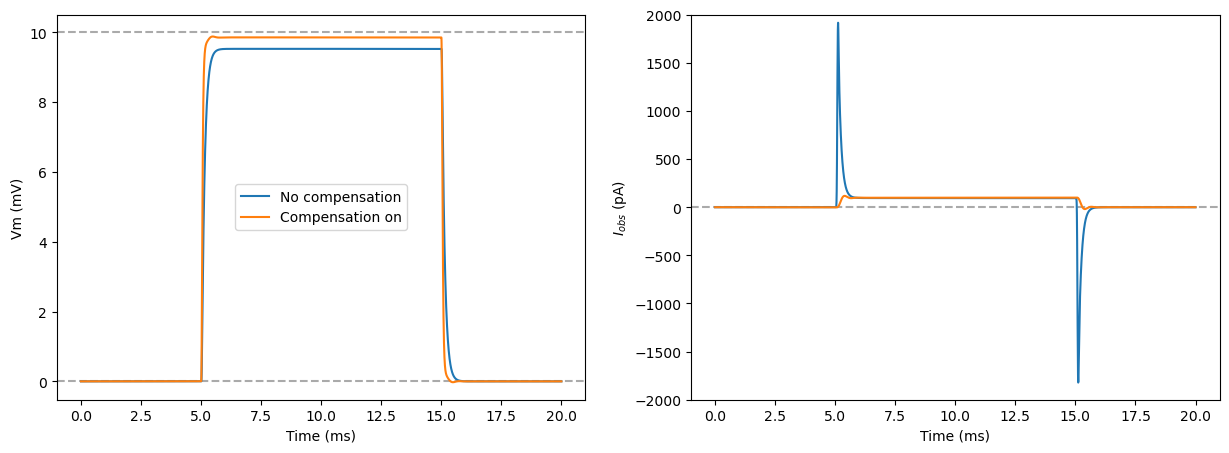

In [17]:
kw = dict(color='#aaa', ls='--')

fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.axhline(0, **kw)
ax.axhline(10, **kw)
ax.plot(dA.time(), dA['amp.Vm'], label='No compensation')
ax.plot(dB.time(), dB['amp.Vm'], label='Compensation on')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('$I_{obs}$ (pA)')
ax.axhline(0, **kw)
ax.plot(dA.time(), dA['amp.I_obs'])
ax.plot(dB.time(), dB['amp.I_obs'])
ax.set_ylim(-2000, 2000)

plt.show()

## Conclusion

In this notebook we have introduced and modelled several types of electronic compensation circuitry found in patch-clamp amplifiers:

1. Zeroing the voltage
2. Frequency response correction
3. Fast and slow capacitative transient cancellation
4. Series resistance correction and prediction
5. Input and output filters

In the next notebook we will discuss _filtering_ of the input and output signals.